In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, UpSampling2D
from keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [8]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


#im = generate_a_rectangle(10, True)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#im = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


In [25]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


<font color = black> 
    
# 3. Simple Classification

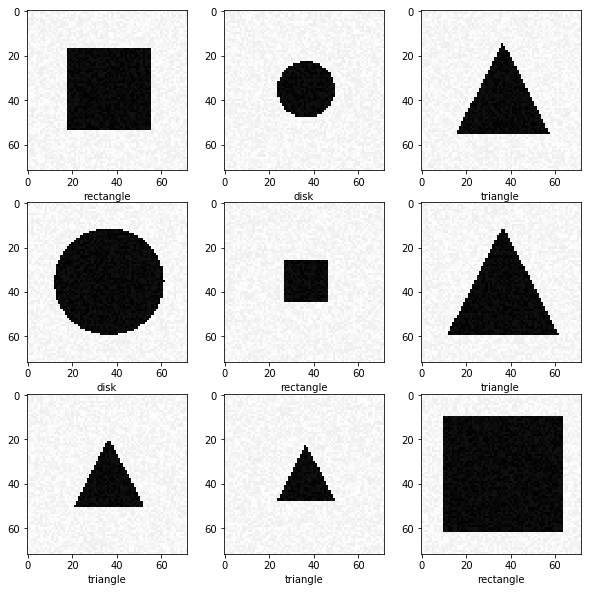

In [26]:
## Visualization of few shapes taken from the generated training set
shape_names = ['rectangle', 'disk', 'triangle']

plt.figure(figsize=(10,10))
for i in range(9):
    # Place of the image in the 5*5 matrix 
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap= 'gray')
    # give a label to the images we generate (0: rectangle; 1: disk, 2: triangle )
    plt.xlabel(shape_names[int(Y_train[i])])

In [27]:
y_train = np_utils.to_categorical(Y_train, 3)

In [28]:
Y_train.shape, y_train.shape

((300,), (300, 3))

<font color = Gray> 
    
# SGD : Stochastic Gradient Descent 

In [29]:
model_sgd = Sequential()
# First Layer with the relu activation 
model_sgd.add(Dense(16, activation = 'relu'))
# Second and final Layer with the softmax activation
model_sgd.add(Dense(3, activation = 'softmax'))

# Optimer definition : SGD 
sgd = SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov=True)
# Loss function with mean squared error 
model_sgd.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['accuracy'])

model_sgd.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 1s 3ms/step - loss: 0.2336 - acc: 0.4292 - val_loss: 0.2206 - val_acc: 0.4833
Epoch 2/20
240/240 [==============================] - 0s 193us/step - loss: 0.2134 - acc: 0.4500 - val_loss: 0.2198 - val_acc: 0.5000
Epoch 3/20
240/240 [==============================] - 0s 245us/step - loss: 0.2014 - acc: 0.6125 - val_loss: 0.1961 - val_acc: 0.5333
Epoch 4/20
240/240 [==============================] - 0s 300us/step - loss: 0.1793 - acc: 0.6417 - val_loss: 0.1761 - val_acc: 0.6167
Epoch 5/20
240/240 [==============================] - 0s 343us/step - loss: 0.1641 - acc: 0.7042 - val_loss: 0.1644 - val_acc: 0.6500
Epoch 6/20
240/240 [==============================] - 0s 256us/step - loss: 0.1520 - acc: 0.7250 - val_loss: 0.1616 - val_acc: 0.5833
Epoch 7/20
240/240 [==============================] - 0s 234us/step - loss: 0.1424 - acc: 0.6958 - val_loss: 0.1409 - val_acc: 0.7500
Epoch 8/20
240/240 

In [37]:
# Check the classifier 
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0]) 
model_sgd.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

<font color = gray> 
    
# Adam

In [39]:
model_adam = Sequential()
# First Layer with the relu activation 
model_adam.add(Dense(16, activation = 'relu'))
# Second Layer with the softmax activation
model_adam.add(Dense(3, activation = 'softmax'))

model_adam.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_adam.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 1s 5ms/step - loss: 3.6742 - acc: 0.3750 - val_loss: 1.0525 - val_acc: 0.6500
Epoch 2/20
240/240 [==============================] - 0s 317us/step - loss: 1.1561 - acc: 0.6458 - val_loss: 0.9561 - val_acc: 0.6667
Epoch 3/20
240/240 [==============================] - 0s 350us/step - loss: 0.7712 - acc: 0.6542 - val_loss: 0.5704 - val_acc: 0.6833
Epoch 4/20
240/240 [==============================] - 0s 329us/step - loss: 0.5628 - acc: 0.6417 - val_loss: 0.5490 - val_acc: 0.6833
Epoch 5/20
240/240 [==============================] - 0s 365us/step - loss: 0.5397 - acc: 0.7125 - val_loss: 0.5493 - val_acc: 0.6500
Epoch 6/20
240/240 [==============================] - 0s 397us/step - loss: 0.5007 - acc: 0.7375 - val_loss: 0.4996 - val_acc: 0.7833
Epoch 7/20
240/240 [==============================] - 0s 338us/step - loss: 0.4824 - acc: 0.7250 - val_loss: 0.4817 - val_acc: 0.6833
Epoch 8/20
240/240 

In [44]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0]) 
model_adam.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

<font color = black> 
    
# 4. Visualization of the Solution

In [46]:
model_sgd.get_weights()[0].shape

(5184, 16)

In [47]:
weights_sgd = model_sgd.get_weights()[0].dot(model_sgd.get_weights()[2])
weights_adam = model_adam.get_weights()[0].dot(model_adam.get_weights()[2])

Text(0.5,1,'Sgd Classifier for triangle')

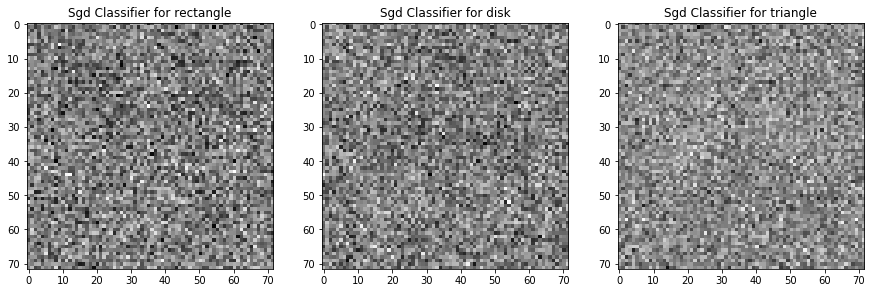

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(weights_sgd[:, 0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[0].set_title('Sgd Classifier for rectangle')

axes[1].imshow(weights_sgd[:, 1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[1].set_title('Sgd Classifier for disk')

axes[2].imshow(weights_sgd[:, 2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[2].set_title('Sgd Classifier for triangle')

Text(0.5,1,'Adam Classifier for triangle')

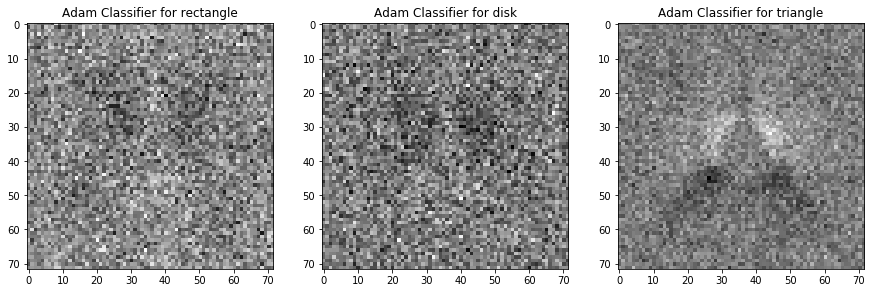

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(weights_adam[:, 0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[0].set_title('Adam Classifier for rectangle')

axes[1].imshow(weights_adam[:, 1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[1].set_title('Adam Classifier for disk')

axes[2].imshow(weights_adam[:, 2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
axes[2].set_title('Adam Classifier for triangle')

<font color = black> 
    
# 5. A More Diﬃcult Classiﬁcation Problem

In [73]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [74]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [75]:
y_train = np_utils.to_categorical(Y_train, 3)

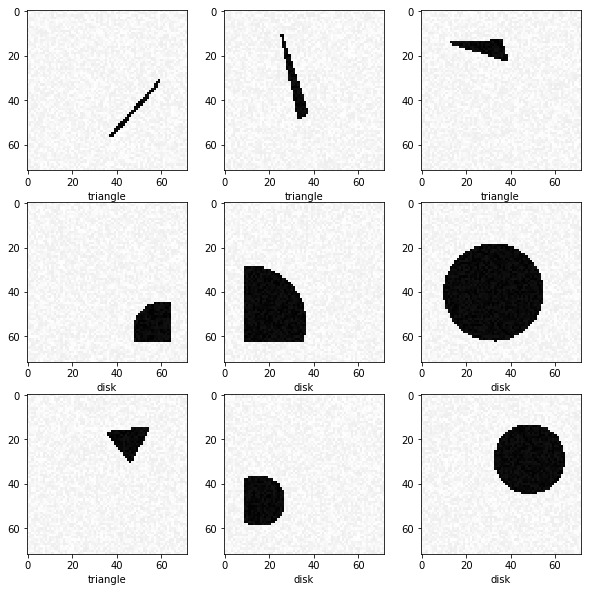

In [88]:
class_names = ['rectangle', 'disk', 'triangle']

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i].reshape(72,72), cmap= 'gray')
    plt.xlabel(class_names[int(Y_train[i])])

In [77]:
model_test = Sequential()
model_test.add(Dense(16, activation = 'relu'))
model_test.add(Dense(3, activation = 'softmax'))

sgd = SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov=True)
model_test.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['accuracy'])

model_test.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 1s 4ms/step - loss: 0.2372 - acc: 0.3208 - val_loss: 0.2207 - val_acc: 0.4667
Epoch 2/20
240/240 [==============================] - 0s 197us/step - loss: 0.2239 - acc: 0.3625 - val_loss: 0.2180 - val_acc: 0.4667
Epoch 3/20
240/240 [==============================] - 0s 253us/step - loss: 0.2180 - acc: 0.4125 - val_loss: 0.2135 - val_acc: 0.4500
Epoch 4/20
240/240 [==============================] - 0s 366us/step - loss: 0.2146 - acc: 0.4708 - val_loss: 0.2196 - val_acc: 0.4667
Epoch 5/20
240/240 [==============================] - 0s 278us/step - loss: 0.2096 - acc: 0.5375 - val_loss: 0.2145 - val_acc: 0.5000
Epoch 6/20
240/240 [==============================] - 0s 279us/step - loss: 0.2129 - acc: 0.4917 - val_loss: 0.2108 - val_acc: 0.5500
Epoch 7/20
240/240 [==============================] - 0s 256us/step - loss: 0.2095 - acc: 0.5167 - val_loss: 0.2292 - val_acc: 0.4000
Epoch 8/20
240/240 

In [81]:
score = model_test.evaluate(X_test, Y_test)
# value of the loss function
print('Test loss:', score[0])
# accuracy of our classifier
print('Test accuracy:', score[1])

300/300 [==============================] - 0s 65us/step
('Test loss:', 0.1985463672876358)
('Test accuracy:', 0.5499999996026357)


In [82]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1) 
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

In [83]:
# convolutional deep network 
model_conv = Sequential()

model_conv.add(Conv2D(32, (5, 5), activation = 'relu', input_shape = (72, 72, 1)))

model_conv.add(MaxPooling2D(pool_size=(2, 2)))

model_conv.add(Flatten())

model_conv.add(Dense(3, activation = 'softmax'))

model_conv.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_conv.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

(None, 68, 68, 32)
(None, 34, 34, 32)
(None, 36992)
(None, 3)
Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 2s 8ms/step - loss: 1.3881 - acc: 0.3292 - val_loss: 1.0832 - val_acc: 0.3000
Epoch 2/20
240/240 [==============================] - 1s 3ms/step - loss: 0.9785 - acc: 0.5000 - val_loss: 1.0778 - val_acc: 0.4000
Epoch 3/20
240/240 [==============================] - 1s 3ms/step - loss: 0.8871 - acc: 0.6125 - val_loss: 0.9270 - val_acc: 0.6167
Epoch 4/20
240/240 [==============================] - 1s 3ms/step - loss: 0.7613 - acc: 0.7917 - val_loss: 0.9181 - val_acc: 0.6000
Epoch 5/20
240/240 [==============================] - 1s 4ms/step - loss: 0.6762 - acc: 0.8292 - val_loss: 0.8483 - val_acc: 0.5833
Epoch 6/20
240/240 [==============================] - 1s 3ms/step - loss: 0.5841 - acc: 0.8833 - val_loss: 0.8086 - val_acc: 0.6167
Epoch 7/20
240/240 [==============================] - 1s 3ms/step - loss: 0.5222 - acc: 0.8667 - val_

In [89]:
score = model_conv.evaluate(X_test, Y_test)
# value of the loss function
print('Test loss:', score[0])
# accuracy of our classifier
print('Test accuracy:', score[1])

300/300 [==============================] - 0s 1ms/step
('Test loss:', 0.6952538609504699)
('Test accuracy:', 0.7066666674613953)


In [85]:
y_conv_pred = model_conv.predict(X_test)

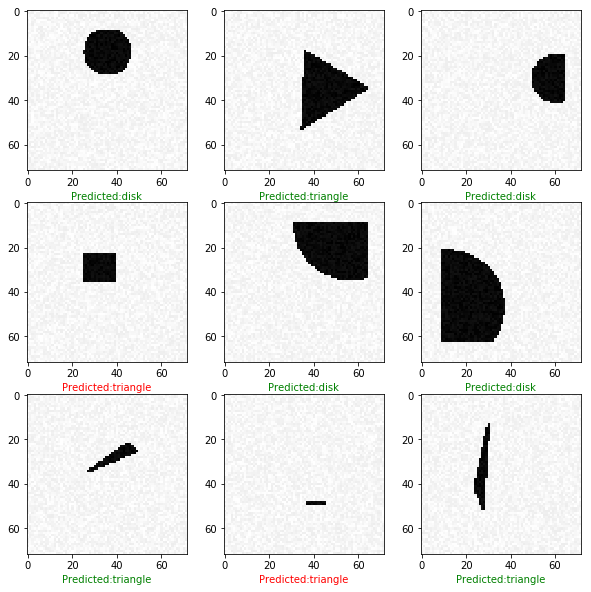

In [90]:
class_names = ['rectangle', 'disk', 'triangle']

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i].reshape(72,72), cmap= 'gray')
    if np.argmax(y_conv_pred[i]) == np.argmax(Y_test[i]):
        plt.xlabel('Predicted:' + class_names[np.argmax(y_conv_pred[i])], color = 'green')
    else:
        plt.xlabel('Predicted:' + class_names[np.argmax(y_conv_pred[i])], color = 'red')
         

<font color = black> 
    
# 6. A Regression Problem

In [91]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


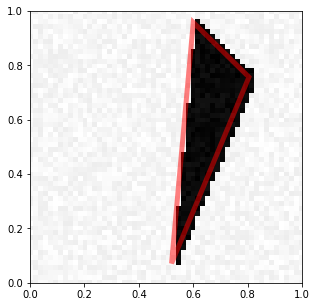

In [94]:
visualize_prediction(X_train[3], Y_train[3])

In [95]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [1]:
def normalizer(array):
    nb_samples = array.shape[0]
    normalized_array = np.copy(array)
    
    for k in range(nb_samples):
        x1, y1, x2, y2, x3, y3 = array[k, 0], array[k, 1], array[k, 2], array[k, 3], array[k, 4], array[k, 5]
        couple = {y1:x1, y2:x2, y3:x3}
        couple_list = list(couple)
        couple_list.sort()
        normalized = []
        
        for key in couple_list:
            normalized.append(couple[key])
            normalized.append(key)
        
        normalized_array[k] = normalized
    
    return(normalized_array)

In [112]:
Y_train_norm = normalizer(Y_train)
Y_test_norm = normalizer(Y_test)
print(Y_train[0])
print(Y_train_norm[0])

[0.94657368 0.90211967 0.27438646 0.22330768 0.55605629 0.07462498]
[0.55605629 0.07462498 0.27438646 0.22330768 0.94657368 0.90211967]


In [38]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1) 
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

In [39]:
X_train.shape

(300, 72, 72, 1)

In [40]:
model_regression = Sequential()

model_regression.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (72, 72, 1)))
model_regression.add(MaxPooling2D(pool_size=(2, 2)))

model_regression.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (72, 72, 1)))
model_regression.add(MaxPooling2D(pool_size=(2, 2)))

model_regression.add(Conv2D(128, (3, 3), activation = 'relu', input_shape = (72, 72, 1)))
model_regression.add(MaxPooling2D(pool_size=(2, 2)))

model_regression.add(Flatten())

model_regression.add(Dense(128, activation = 'relu'))

model_regression.add(Dense(6, activation = 'linear'))

model_regression.compile(loss = 'mean_squared_error', optimizer = 'adam')

model_regression.fit(X_train, Y_train_norm, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 4s 15ms/step - loss: 0.1664 - val_loss: 0.1026
Epoch 2/20
240/240 [==============================] - 2s 7ms/step - loss: 0.0845 - val_loss: 0.0670
Epoch 3/20
240/240 [==============================] - 2s 7ms/step - loss: 0.0659 - val_loss: 0.0623
Epoch 4/20
240/240 [==============================] - 2s 7ms/step - loss: 0.0504 - val_loss: 0.0411
Epoch 5/20
240/240 [==============================] - 2s 7ms/step - loss: 0.0358 - val_loss: 0.0370
Epoch 6/20
240/240 [==============================] - 2s 8ms/step - loss: 0.0321 - val_loss: 0.0343
Epoch 7/20
240/240 [==============================] - 2s 8ms/step - loss: 0.0280 - val_loss: 0.0360
Epoch 8/20
240/240 [==============================] - 2s 7ms/step - loss: 0.0250 - val_loss: 0.0289
Epoch 9/20
240/240 [==============================] - 2s 8ms/step - loss: 0.0213 - val_loss: 0.0287
Epoch 10/20
240/240 [==============================] -

In [41]:
model_regression.evaluate(X_test, Y_test_norm)

300/300 [==============================] - 1s 3ms/step


0.015695138424634932

In [42]:
y_pred = model_regression.predict(X_test)

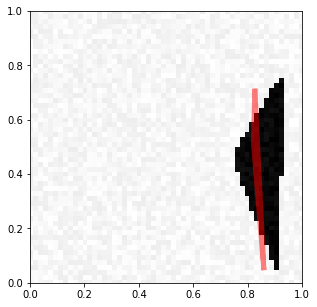

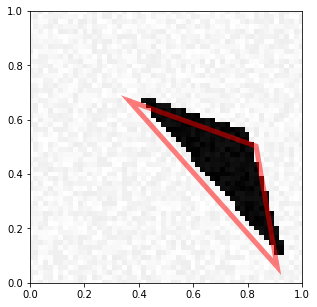

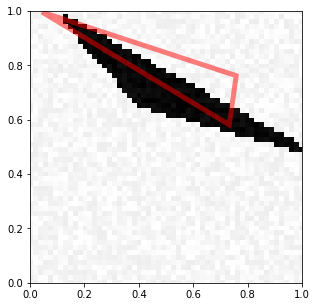

In [43]:
visualize_prediction(X_test[4], y_pred[4])
visualize_prediction(X_test[5], y_pred[5])
visualize_prediction(X_test[6], y_pred[6])

<font color = black> 
    
# Image Denoising

In [6]:
# Modifying our generates function to get two images as output

def generate_a_rectangle_2(noise, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)

def generate_a_disk_2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise) , generate_a_drawing(figsize, U, V, 0)

def generate_a_triangle_2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    
    imdata = generate_a_drawing(figsize, U, V, 0)
    imdata_noise = generate_a_drawing(figsize, U, V, noise)
    return [imdata_noise,imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

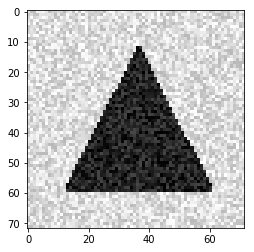

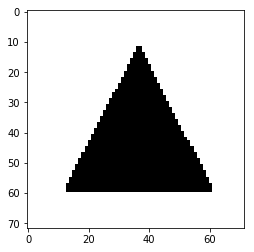

In [23]:
# Plotting our two images 
[im, im_noise, v] = generate_a_triangle_2(100, False)
plt.imshow(im.reshape(72,72), cmap='gray')
plt.show()
plt.imshow(im_noise.reshape(72,72), cmap='gray')
plt.show()

In [12]:
# Here is our new dataset generations using our new generates function
import random as rd

def generate_a_dataset(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_2(0)[0].shape[0]
    X = np.zeros([nb_samples,im_size])   #Images with noise
    Y = np.zeros([nb_samples,im_size])   #Images without noise
    for i in range(nb_samples):
        category = np.random.randint(3)
        #Each image is generated with a different random level of noise
        noise =rd.randint(20,150)
        if category == 0:
            X[i] , Y[i]= generate_a_rectangle_2(noise, free_location)
        elif category == 1: 
            X[i] , Y[i]= generate_a_disk_2(noise, free_location)
        else:
            [X[i], Y[i], V] = generate_a_triangle_2(noise, free_location)
    X = (X + 0) / (255 + 2 * 0)
    Y = (Y + noise) / (255 + 2 * noise)
    return [X, Y]

In [13]:
# Generating the noisy training and test set
[X_train_noise, Y_train_noise] = generate_a_dataset(300)
[X_test_noise, Y_test_noise] = generate_a_dataset(300)

In [14]:
# Formatting the input for the training
X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], 72, 72, 1)
X_train_noise = X_train_noise.astype('float32')
print(X_train_noise.shape)

# Formatting the output for the training
Y_train_noise = Y_train_noise.reshape(Y_train_noise.shape[0], 72, 72, 1)
Y_train_noise = Y_train_noise.astype('float32')
print(Y_train_noise.shape)


# Formatting the input
Y_test_noise = Y_test_noise.reshape(Y_test_noise.shape[0], 72, 72, 1)
Y_test_noise = Y_test_noise.astype('float32')
print(Y_test_noise.shape)

(300, 72, 72, 1)
(300, 72, 72, 1)
(300, 72, 72, 1)


In [15]:
from keras.layers import Input
input_img = Input(shape=(72,72,1))

In [20]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

autoencoder.fit(X_train_noise, Y_train_noise, epochs=50, batch_size=128, shuffle=True, validation_split=0.3)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 1)         289       
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Train on

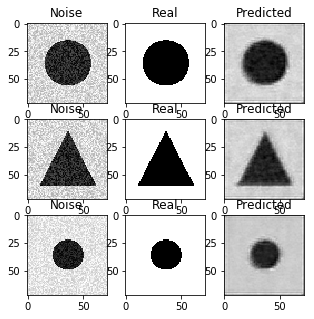

In [24]:
# Here we will do our prediction
pred_noise = autoencoder.predict(X_train_noise)

# And observe the predictions from our model by plotting the Noisy, Real and Predicted figures
nb_img_test = 3
pos =1

fig, axes = plt.subplots(3, 3,figsize=(5,5))

for j in range(nb_img_test):
    
    i=rd.randint(0,299)   
    
    axes[j, 0].imshow(X_train_noise[i].reshape(72,72), cmap='gray')
    axes[j, 0].set_title('Noise')

    axes[j, 1].imshow(Y_train_noise[i].reshape(72,72), cmap='gray')
    axes[j, 1].set_title('Real')
    
    axes[j, 2].imshow(pred_noise[i].reshape(72,72), cmap='gray')
    axes[j, 2].set_title('Predicted')

We see that the model is capable of capturing the figure and reducing the noise around it 